In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
import matplotlib.pyplot as plt

# Implementando una Red Convolucional



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self, x):
    # Starts with 3 x 64 x 64
    x = self.conv1(x) # num_channels x 64 x 64
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
    x = self.conv2(x) # num_channels*2 x 32 x32
    x = F.relu(F.max_pool2d(x,2)) # num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x 16 x 16
    x = F.relu(F.max_pool2d(x,2)) # num_channels*4 x 8 x 8
    
    #flatten
    x = x.view(-1, self.num_channels*4*8*8) # num_channels*4 x 8 x 8
    
    #FC finales
    x = self.fc1(x) # out_fc1
    x = F.relu(x)
    x = self.fc2(x) # out_fc2
    
    # log_softmax
    
    x = F.log_softmax(x, dim=1)
    
    return x

In [0]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
net = Net(32).to(device)

In [0]:
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3          [-1, 128, 16, 16]          73,856
            Linear-4                  [-1, 128]       1,048,704
            Linear-5                    [-1, 6]             774
Total params: 1,142,726
Trainable params: 1,142,726
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.75
Params size (MB): 4.36
Estimated Total Size (MB): 6.16
----------------------------------------------------------------


# Datasets y Dataloaders

In [0]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [0]:
import os 
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [0]:
class SIGNSDataset(Dataset):
  "Ejemplo de como construir un dataset de imagenes"
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [0]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS')

In [0]:
len(signs)

864

2


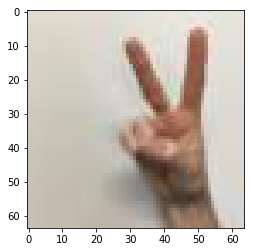

In [0]:
image, target = signs[0]

plt.imshow(image)
print(target)

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS',transform=transforms.ToTensor())

In [0]:
dataloader = DataLoader(trainset,batch_size=32)

In [0]:
from plot_helpers import imshow
from torchvision.utils import make_grid

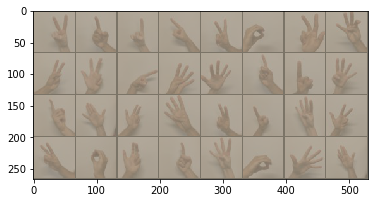

tensor([2, 1, 1, 1, 2, 0, 3, 4, 2, 3, 1, 4, 5, 1, 1, 4, 1, 5, 3, 4, 2, 1, 4, 3,
        2, 0, 3, 1, 4, 0, 5, 5])


In [0]:
for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

# Entrenar nuestra red

In [0]:
import torch.optim as optim

In [0]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss() #Metrica de acierto de la red
optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum = 0.9)

In [0]:
net.train() #ciertas capas se transforman distinto en entrenamiento que en inferencia

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [0]:
num_epochs = 100 #un epoch es una pasada completa sobre todo el dataset

In [0]:
class RunningMetric():
    # Clase util para calcular metricas del entrenamiento
    def __init__(self):
        self.S = 0
        self.N = 0
        
    
    def update(self, val, size):
        self.S += val
        self.N += size
    
    def __call__(self):
        return self.S/float(self.N)

In [0]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-' *10)
  
  running_loss = RunningMetric() #metrica de perdida
  running_acc = RunningMetric() #metrica de precision de las predicciones
  
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device) #pasar tensores a gpu
    optimizer.zero_grad() # Dejar gradientes en zero (para no acumular del batch anterior)
    
    outputs = net(inputs) #pasar por la red el batch de imagenes
    _, preds = torch.max(outputs,1)
    loss = loss_fn(outputs, targets) #perdida en el batch
    
    loss.backward() #magia! calcula gradientes automaticamente
    optimizer.step() #magia2: optimiza los parametros ligeramente para mejorar performance
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                      batch_size)
    
  print('{} Loss: {:.4f} Acc: {:.4f}'.format("train",
                                            running_loss(),
                                            running_acc())) 

Epoch 1/100
----------
train Loss: 1.7928 Acc: 0.1690
Epoch 2/100
----------


KeyboardInterrupt: ignored

# Autograd y Comparación de métodos de optimización



In [0]:
# Funcion Lineal

x = torch.Tensor(2)
x.requires_grad=True #cualquier operacion sobre x será tomada en cuenta para calcular el gradiente
loss = 13*x[0] - 7*x[1] + 1
loss.backward()
print(x)
x.grad

In [0]:
# Suma de elementos de columna inferior a 4

x = torch.Tensor(4, 10)
x.requires_grad=True 

loss = x[:, :4]
loss = loss.sum()
loss.backward()
x.grad

In [0]:
x = torch.rand((2,3),requires_grad=True)
y = torch.Tensor([[1, 2], [3, 4]])
loss = y.mm(x)
loss = loss.sum()
loss.backward()
x.grad # L = (4,4,4)*L1^t + (6,6,6)*L2^t

In [0]:
## Que hace optimizer.step? Caso GD

with torch.no_grad(): #context manager: queremos updatear los valores, no cambiar el grafo de computo
  x -= 0.01 * x.grad

In [0]:
import optimizers_viz as optviz

In [0]:
problem = optviz.build_beales_problem()
constructors = optviz.build_optimizers(problem.lr)
params = optviz.build_params(problem)

In [0]:
optviz.plot_minimized_function(params)

In [0]:
constructors

In [0]:
zpaths, results, distance, lrs = optviz.run_optimizers(problem, constructors, params)

In [0]:
optviz.plot_optim_journeys(zpaths, results, distance, lrs, params)

In [0]:
optviz.plot_3D_journey(zpaths, results, problem, params)

In [0]:
%%html

<iframe width="800" height="600"
src="https://www.youtube.com/embed/tE1uwugppkY?autoplay=1&showinfo=0&controls=0"
allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen
>

</iframe>

# Evaluación 



In [0]:
# Carge de los tres splits de datos

trainset = signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', transform=transform)
trainloader = DataLoader(trainset,batch_size=32)

valset = signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='val', transform=transform)
valloader = DataLoader(trainset,batch_size=32)

testset = signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='test', transform=transform)
testloader = DataLoader(trainset,batch_size=32)

dataloaders = {'train': trainloader,
              'val': valloader,
              'test': testloader}

In [0]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epochs = 10):    
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
      
            running_acc = RunningMetric()
            running_loss = RunningMetric()

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = loss_fn(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.size()[0]
                running_acc.update(torch.sum(preds == targets.data).float(), 
                                   batch_size)
                running_loss.update(loss.item()*batch_size,
                                    batch_size)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, running_loss(), running_acc()))

    return model

# Añadiendo regularización

In [0]:
#data augmentation

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), #data augmentation
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.num_channels = 32
        self.dropout_rate = 0.8


        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)


        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)
        


    def forward(self, s):
        # 3 pasadas convolucionales: conv -> max_pool -> relu   
                                                            # batch_size x 3 x 64 x 64
        s = self.bn1(self.conv1(s))                         # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.bn2(self.conv2(s))                                  # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.bn3(self.conv3(s))                                  # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # FC final con 2 capas
        s = F.relu(self.fcbn1(self.fc1(s)))                 # batch_size x self.num_channels*4
        s = F.dropout(s, p=self.dropout_rate,               # batch_size x self.num_channels*4
                      training=self.training)
        s = self.fc2(s)                                     # batch_size x 6

        # log_softmax para salida
        return F.log_softmax(s, dim=1)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
train_and_evaluate(net,optimizer,loss_fn,dataloaders,device)

In [0]:
from plot_helpers import visualize_model

visualize_model(net, dataloaders, device)

# Optimización de hiperparametros

In [0]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, scheduler, device, num_epochs = 10, lr = 0.001):   
    for g in optimizer.param_groups:
      g['lr'] = lr
    
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
      
            running_acc = RunningMetric()
            running_loss = RunningMetric()

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = loss_fn(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.size()[0]
                running_acc.update(torch.sum(preds == targets.data).float(), 
                                   batch_size)
                running_loss.update(loss.item()*batch_size,
                                    batch_size)
                
            if phase == 'train':
              scheduler.step()
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, running_loss(), running_acc()))

    return model

In [0]:
import random

lrs = [10**(-random.randint(3,7)) for _ in range(3)]

In [0]:
from torch.optim.lr_scheduler import StepLR

step_scheduler = StepLR(optimizer, step_size=30, gamma=0.1) #learning rate decay

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, scheduler, device, num_epochs = 10, lr = 0.001):   
    for g in optimizer.param_groups:
      g['lr'] = lr
    
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
      
            running_acc = RunningMetric()
            running_loss = RunningMetric()

            for inputs, targets in dataloaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = loss_fn(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.size()[0]
                running_acc.update(torch.sum(preds == targets.data).float(), 
                                   batch_size)
                running_loss.update(loss.item()*batch_size,
                                    batch_size)
                
            if phase == 'train':
              scheduler.step()
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, running_loss(), running_acc()))

    return model

In [0]:
for lr in lrs:
  train_and_evaluate(net,optimizer,loss_fn,dataloaders, step_scheduler, device, 10, lr)

# Construyendo las Redes para CycleGAN

In [0]:
%cd '/gdrive/My Drive/'

In [0]:
!git clone https://github.com/aitorzip/PyTorch-CycleGAN.git

In [0]:
%cd '/gdrive/My Drive/PyTorch-CycleGAN'

In [0]:
%%sh
sh ./download_dataset summer2winter_yosemite

In [0]:
!mv datasets/summer2winter_yosemite/ /gdrive/My\ Drive/dl-pytorch/datasets/

In [0]:
!ls /gdrive/My\ Drive/dl-pytorch/datasets/

# CycleGAN

In [0]:
class Generator(nn.Module):
  def __init__(self, input_nc, output_nc, n_residual_blocks=9):
    super(Generator,self).__init__()
    
    model = [ nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
             nn.ReLU(True)
            ]
    
    in_features = 64
    out_features = in_features * 2
    
    for _ in range(2):
      model += [ nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(True)
               ]
      in_features = out_features
      out_features = in_features*2
    
    for _ in range(n_residual_blocks):
      model += [ResidualBlock(in_features)]
    
    out_features = in_features//2
    for _ in range(2):
      model += [ nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(True)
               ]
      in_features = out_features
      out_feature = in_features //2
      
      model += [ nn.ReflectionPad2d(3),
                 nn.Conv2d(64, output_nc, 7),
                 nn.Tanh()
               ]
      
      self.model = nn.Sequential(*model)
      
  def forward(self,x):
    return self.model(x)
  
class Generator(nn.Module):
  def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

  def forward(self, x):
      return self.model(x)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    ## Un bloque residual permite que agregar capas agrande el espacio de modelos de forma imbricadas
    ## Resnet es ganador de Imagenet 2015 y una de las mejores redes actualmente
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        #Bloque que no modifica el tamaño
        conv_block = [  nn.ReflectionPad2d(1),  # Mejor que zero-padding
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features), #"BN para Style Transfer". Normaliza el contraste.
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ] #in_features: canales

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x) #una idea profunda pero implementada simplemente

class Generator(nn.Module):
  "Convolucion - compresion - resblock -  "
  def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        "Convolucion encoding decoding salida"
        super(Generator, self).__init__()

        # Bloque Convolucional      
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7), # (I - 7 + 6) / 2 + 1 = I
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling ("compression")
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1), #(I - 3 + 2)/2 + 1 = (I-1)/2 +1 (parte entera) = I/2
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Bloques residuales
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling ("Deconvolution")
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1), # I*S - 2P + F + O_p = 2I
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Capa de Salida
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7), # I-7+6/1 +1 = I
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

  def forward(self, x):
      return self.model(x)

class Discriminator(nn.Module):
    "PatchGAN: discrimina al nivel de patches. Int: perdida de estilo o textura"
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # Convoluciones de filtro 4, stride 2 y padding 1 a.k.a 0 = I - 4 + 2 / 2 +1 = I/2
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1), #I-1
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # Flatten
        model += [nn.Conv2d(512, 1, 4, padding=1)] #I-1

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling y flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1) #filtro del tamaño de la imagen -> promedio

In [0]:
%cd '/gdrive/My Drive/dl-pytorch'

/gdrive/My Drive/dl-pytorch


In [0]:
!pip install livelossplot

In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
import glob
import random
import os
import itertools
import os
import sys
from PIL import Image

import torch

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

from utils import ReplayBuffer, Logger

from livelossplot import PlotLosses

class ImageDataset(Dataset):
  def __init__(self, base_dir, transform=None, unaligned=False, split='train'):
      self.transform = transforms.Compose(transform)
      self.unaligned = unaligned
      
      self.files_A = sorted(glob.glob(os.path.join(base_dir, '{}/A/*.*'.format(split))))
      self.files_B = sorted(glob.glob(os.path.join(base_dir, '{}/B/*.*'.format(split))))
      
  def __len__(self):
      return max(len(self.files_A), len(self.files_B))
    
  def __getitem__(self, idx):
    image_A = self.transform(Image.open(self.files_A[idx]))
    item_B = self.transform(Image.open(self.files_B[random.randint(0,len(self.files_B)-1)]))
    return {'A': image_A, 'B': item_B}
  
epoch=0
n_epochs = 200
batch_size = 2
lr = 0.0002
size = 256
input_nc = 3
output_nc = 3
decay_epoch= 100 #pending

cuda = True
n_cpu = 8

base_dir = '/gdrive/My Drive/dl-pytorch/datasets/summer2winter_yosemite/'

In [0]:
device = torch.device('cuda' if cuda else 'cpu')

# initialize tensors
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

# Redes
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

if cuda:
    netG_A2B.to(device)
    netG_B2A.to(device)
    netD_A.to(device)
    netD_B.to(device)

# Funciones de perdida
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizadores
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Schedulers

# compute decay
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)
      

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  import sys


In [0]:
# Inputs y targets 
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
target_real = Tensor(batch_size).fill_(1.0)
target_fake = Tensor(batch_size).fill_(0.0)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataloader
transform = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

dataloader = DataLoader(ImageDataset(base_dir, transform=transform, unaligned=True), 
                        batch_size=batch_size, shuffle=True, num_workers=n_cpu, drop_last=True)

def Gen_GAN_loss(G, D, real, loss, target_real):
          fake = G(real)
          pred_fake = D(fake)
          L = loss(pred_fake, target_real)
          return L, fake

def cycle_loss(G1, G2, real, loss):
  recovered = G2(G1(real))
  L = loss(recovered, real)
  return L 
        
def identity_loss(G,real,loss):
  same = G(real)
  L = loss(same,real)
  return L
        


In [0]:
# Entrenamiento
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        # Input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        ###### Generadores A2B y B2A ######
        optimizer_G.zero_grad()
        
        
          
        loss_GAN_A2B, fake_B  = Gen_GAN_loss(netG_A2B, netD_B, real_A, criterion_GAN, target_real)
        loss_GAN_B2A, fake_A  = Gen_GAN_loss(netG_B2A, netD_A, real_B, criterion_GAN, target_real)
        
        loss_cycle_ABA = cycle_loss(netG_A2B, netG_B2A, real_A, criterion_cycle)
        loss_cycle_BAB = cycle_loss(netG_B2A, netG_A2B, real_B, criterion_cycle)
        
        loss_identity_A = identity_loss(netG_B2A, real_A, criterion_identity)
        loss_identity_B = identity_loss(netG_A2B, real_B, criterion_identity)        

        loss_G =  (loss_GAN_A2B + loss_GAN_B2A) + 10.0 * (loss_cycle_ABA + loss_cycle_BAB) + 5.0 * (loss_identity_A + loss_identity_B)
        loss_G.backward()
        
        optimizer_G.step()
        
        
          

        # Discriminador A
        optimizer_D_A.zero_grad()
        loss_D_A = Disc_GAN_loss(netD_A, fake_A, real_A, fake_A_buffer, criterion_GAN, target_real, target_fake)
        loss_D_A.backward()
        optimizer_D_A.step()
        
        optimizer_D_B.zero_grad()
        loss_D_B = Disc_GAN_loss(netD_B, fake_B, real_B, fake_B_buffer, criterion_GAN, target_real, target_fake)
        loss_D_B.backward()
        optimizer_D_B.step()

       
    
    
    liveloss.update(log_values)
    liveloss.draw()

    # Update de los learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()   

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 000/200 [0141/0615] -- loss_G: 9.4449 | loss_G_identity: 0.5503 | loss_G_GAN: 0.7294 | loss_G_cycle: 0.5964 | loss_D: 0.5311 -- ETA: -3 days, 6:47:17.457121

In [0]:
 # Reportería del progreso del entrenamiento (http://localhost:8097)
        

In [0]:
# Guardar checkpoints
    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')

# Entrenamiento de CycleGAN